## In seek of the answer to the question: "Am I software developer or engineer?"

### (1) Imports

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pickle as pkl

In [5]:
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

### (2) Prepare manipulators

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/michal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
st_voc = stopwords.words('english')

### (3) Load job specifications

Obtain US Dice jobs

In [10]:
jobs_df = pd.read_csv('datasets/us_dice.csv.zip')

### (4) Prepare data

#### Process titles

##### Lowercase titles

In [11]:
jobs_df['title'] = jobs_df['title'].str.lower()

##### Remove managerial roles

In [12]:
jobs_df = jobs_df[~jobs_df.title.str.contains('manager')].copy()

##### Normalize titles

In [13]:
conditions = [
    (
        (jobs_df.title.str.contains('engineer') | jobs_df.title.str.contains('engineering'))
    ),
    (
        (jobs_df.title.str.contains('developer') | jobs_df.title.str.contains('development'))
    )
]
choices = ['software engineer', 'software developer']
jobs_df['title'] = np.select(conditions, choices, default=jobs_df['title'])

##### Data check: classes count

In [14]:
total = 0
for title in choices:
    resumes_no = len(jobs_df[jobs_df['title'] == title])
    print("%s: %s" % (title, resumes_no))
    total = total + resumes_no

software engineer: 4690
software developer: 5258


##### Remove unused (not belonging to our classes)

In [15]:
jobs_df = jobs_df[jobs_df['title'].isin(choices)].copy()

#### Process descriptions (loosely from https://medium.com/analytics-vidhya/classifying-tech-data-job-postings-on-indeed-com-1fd8ca6e7cdd)

##### Lowercase descriptions

In [16]:
jobs_df['description'] = jobs_df['description'].str.lower()

##### Remove paragraphs from descriptions and remove empty records

In [17]:
jobs_df['description'] = jobs_df.description.str.replace("\\n", " ")

In [18]:
jobs_df = jobs_df.dropna(subset=['description'])

##### Tokenize descriptions

In [19]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

In [20]:
jobs_df["tokens"] = jobs_df.apply(lambda row: tokenizer.tokenize(row['description']), axis=1)

In [21]:
jobs_df = jobs_df.dropna(subset=['tokens'])

##### Remove stopwords from descriptions

In [22]:
jobs_df["tokens"] = jobs_df['tokens'].apply(lambda x: [item for item in x if item not in st_voc])

##### Convert descriptions back into strings

In [23]:
jobs_df["t_description"] = [" ".join(txt) for txt in jobs_df["tokens"].values]

### (5) Generate labels

In [24]:
encoder = LabelEncoder()
y = encoder.fit_transform(jobs_df.title)

#### Obtain label name/ID pairs

In [25]:
l_names = encoder.inverse_transform(np.unique(y))

In [26]:
for (i, item) in enumerate(l_names):
    print(i, item)

0 software developer
1 software engineer


### (6) Feature vectors - create vocabulary

#### (6a) Features from dataset

In [27]:
# v = TfidfVectorizer(max_features=200, ngram_range=(1, 3), binary=True, use_idf=False, norm=None)

#### (6b) Features vocabulary

In [49]:
v = TfidfVectorizer(vocabulary=vocabulary, ngram_range=(1, 3), binary=True, use_idf=False, norm=None)

#### Create features in dataset

In [50]:
x = jobs_df["t_description"]
v.fit(x)
x_tfidf = v.transform(x)

### (7) Create classifier

In [51]:
s = svm.LinearSVC(C=1.0, max_iter=5000)

In [52]:
s.fit(x_tfidf, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [53]:
s_pred = s.predict(x_tfidf)

In [54]:
print("SVM Accuracy Score -> ",accuracy_score(s_pred, y)*100)

SVM Accuracy Score ->  70.58705267390431


### (8) Visualization

In [55]:
confusion_matrix(y, s_pred, labels=np.unique(y))

array([[4320,  938],
       [1988, 2702]])

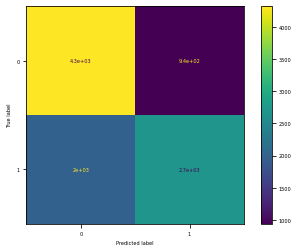

In [56]:
plot_confusion_matrix(s, x_tfidf, y)

In [57]:
def f_importances(coef, names):
    imp = coef
    features = sorted(zip(imp,names))
    imp,names = zip(*features[-50:])
    plt.figure(figsize=(1,5), dpi=240)
    plt.rcParams.update({'font.size': 5})
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    return names

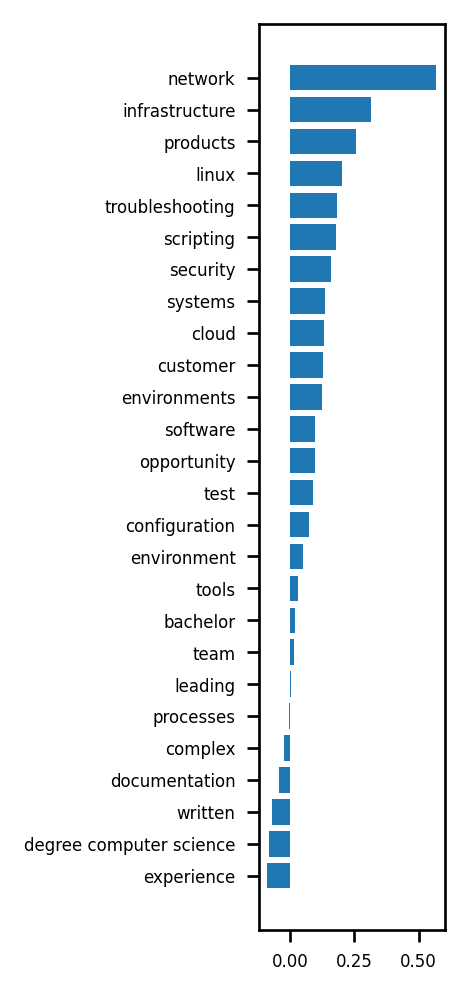

In [58]:
vocabulary = f_importances(s.coef_[0], v.get_feature_names())

### (9) Save the model

In [59]:
with open('model/model.pkl', 'wb') as handle:
    pkl.dump(s, handle, protocol=pkl.HIGHEST_PROTOCOL)

### (10) Show mapping

In [60]:
v.vocabulary_

{'leading': 0,
 'team': 1,
 'processes': 2,
 'environments': 3,
 'bachelor': 4,
 'cloud': 5,
 'experience': 6,
 'environment': 7,
 'customer': 8,
 'configuration': 9,
 'written': 10,
 'complex': 11,
 'degree computer science': 12,
 'documentation': 13,
 'software': 14,
 'opportunity': 15,
 'products': 16,
 'security': 17,
 'systems': 18,
 'tools': 19,
 'troubleshooting': 20,
 'scripting': 21,
 'test': 22,
 'linux': 23,
 'infrastructure': 24,
 'network': 25}

### (11) Vocabulary cleaning

#### Some of the features aren't skills or contain 'engineering', 'development' or 'software' words. Let's clean the result manually and then run the notebook from uncommented (6b).

In [40]:
to_remove = ['work', 'level', 'using', 'ensure', 'customers', 'benefits', 'minimum', 'qualifications', 'also',
             'preferred', 'working', 'us', 'current', 'equivalent', 'role', '10', 'professional', 'degree',
             'join', 'use', 'computer', 'engineering', 'engineers', 'engineer']

In [41]:
vocabulary = [x for x in vocabulary if x not in to_remove]

### (12) Sanity check

In [61]:
s.predict(x_tfidf.toarray()[0:3])

array([1, 1, 0])

In [62]:
software_engineer = x_tfidf.toarray()[0]

In [63]:
software_engineer

array([0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 0., 0., 0.])

In [64]:
s.predict([software_engineer])

array([1])

In [65]:
software_developer = x_tfidf.toarray()[2]

In [66]:
software_developer

array([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0.])

In [67]:
s.predict([software_developer])

array([0])